## Visualizing result from tensorboard. 
#### from tutorial: https://www.tensorflow.org/tensorboard/dataframe_api

#### The following packages are required:  
```
pip install tensorboard pandas
pip install matplotlib seaborn
```

In [43]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use(r"configs/paper_plot_style.mplstyle")
import seaborn as sns
import json
from scipy import stats
import os
import numpy as np

from pathlib import Path
%matplotlib inline

## Helper functions

In [82]:
def get_avg_per_uav(data):
    return 
def get_data(all_progress):

    # data_dict = {parameter: [] for parameter in parameter_list}
    data_dict = {}

    for progress in all_progress:
        with open(str(progress.absolute()), "r") as f:
            try:
                data = json.loads(f.readlines()[-1])
            except Exception as e:
                f.seek(0)
                # data = json.loads(f.readlines()[-2])
                print(f"error reading {progress.absolute()} skipping.")
                continue
            data["target_v"] = data["env_config"]["target_v"]
            data["safe_action"] = data["env_config"]["use_safe_action"]
            data["num_obs"] = data["env_config"]["num_obstacles"]
            data["seed"] = data["env_config"]["seed"]
            data["uav_done"] = np.average(data["uav_done"], axis=1).sum()
            uav_done_time = np.nan_to_num(np.array(data["uav_done_time"], dtype=np.float64), nan=100)
            # print(uav_done_time)
            data["uav_done_time"] = np.nanmean(uav_done_time)
            for k, v in data.items():
                if k not in data_dict:
                    data_dict[k] = []
                data_dict[k].append(v)
            data_dict['file_name'] = progress.absolute()
            
    df = pd.DataFrame(data_dict)
    return df
                    

In [112]:

EXP_FOLDER = r'/home/prime/Documents/workspace/uav_sim/results/test_results/exp_2023-05-28-00-55_a8086c4'


basedir_path = Path(EXP_FOLDER)
basedir_list = list(basedir_path.glob("**/result.json"))
image_folder = basedir_path / "images"

if not image_folder.exists():
    image_folder.mkdir(parents=True,exist_ok=True)

df = get_data(basedir_list)
df.head

<bound method NDFrame.head of     num_episodes  uav_collision  obs_collision  uav_done  uav_done_time  \
0            100            0.0           15.0      3.87       21.90100   
1            100           30.0           78.0      4.00       18.77300   
2            100           18.0           34.0      4.00       18.73700   
3            100          560.0          257.0      4.00       19.03925   
4            100          436.0          190.0      4.00       19.03150   
5            100          960.0          510.0      4.00       18.38375   
6            100          412.0          119.0      4.00       19.03825   
7            100           22.0           53.0      3.99       18.99700   
8            100          532.0          271.0      4.00       19.03425   
9            100          574.0          327.0      4.00       18.42100   
10           100          296.0          731.0      4.00       18.41775   
11           100          184.0           14.0      3.97       19.7965

In [113]:
obs_group = df.groupby(["num_obs", "safe_action"])
obs_group.groups.keys()


dict_keys([(20, False), (20, True), (30, False), (30, True)])

In [114]:
obs_group.get_group((20, False)).uav_done_time


4     19.03150
5     18.38375
6     19.03825
9     18.42100
14    19.03100
21    18.42625
Name: uav_done_time, dtype: float64

In [115]:
# nominal parameters
NUM_PURSUERS = 4
NUM_OBSTACLES = 6
OBSERVATION_RADIUS = 20

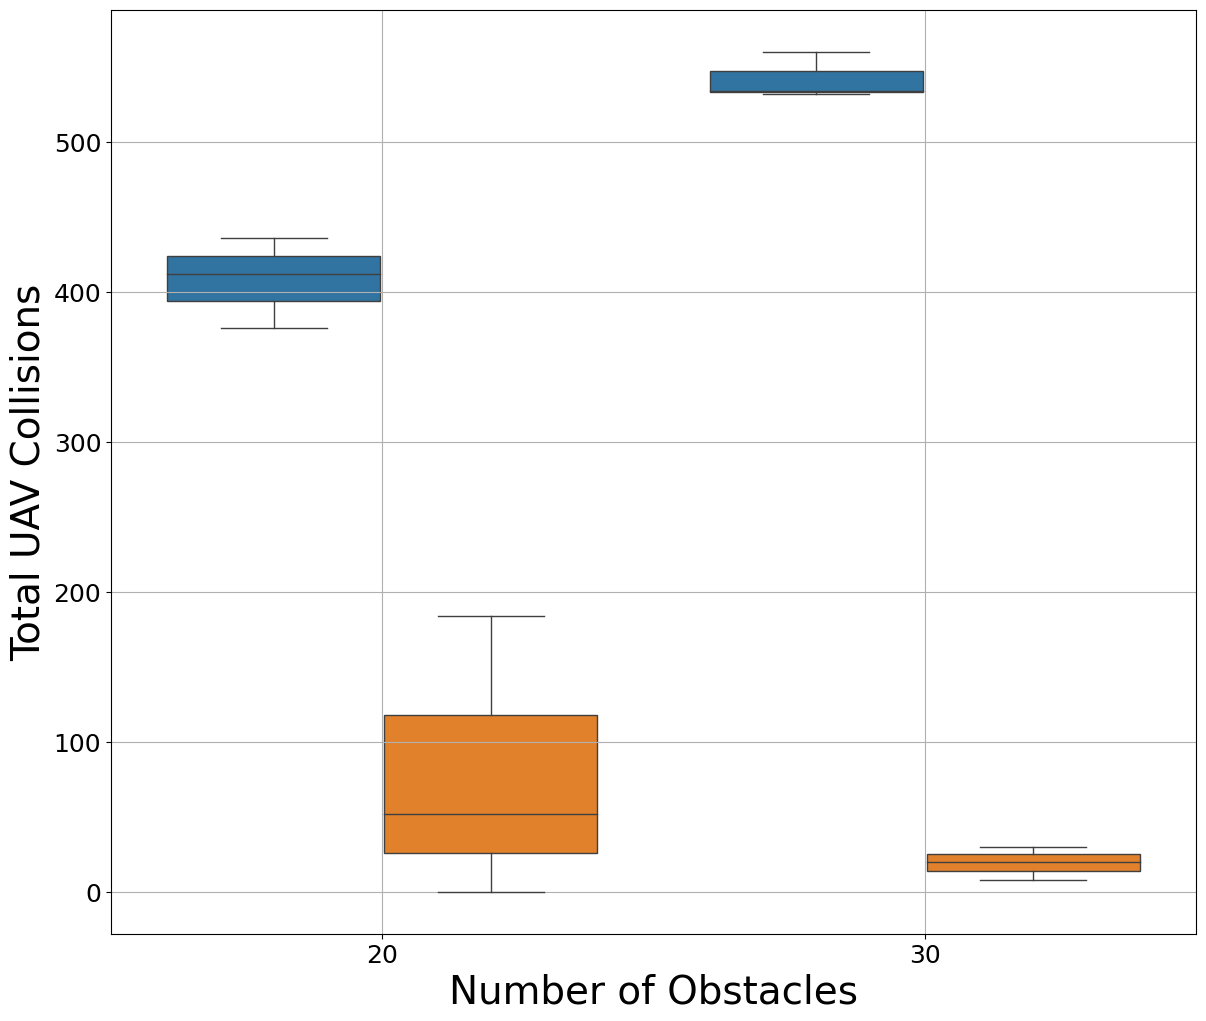

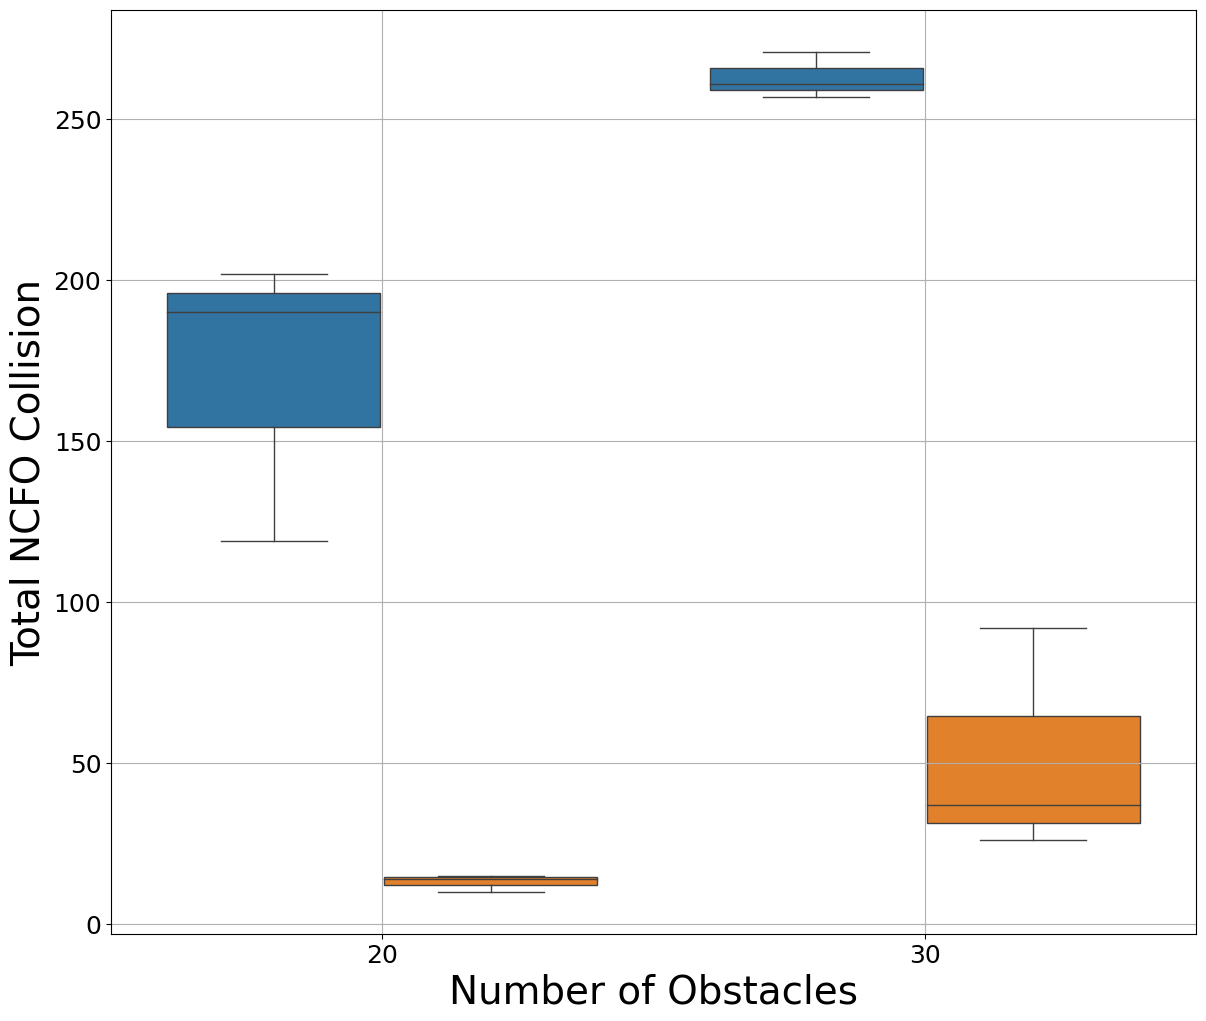

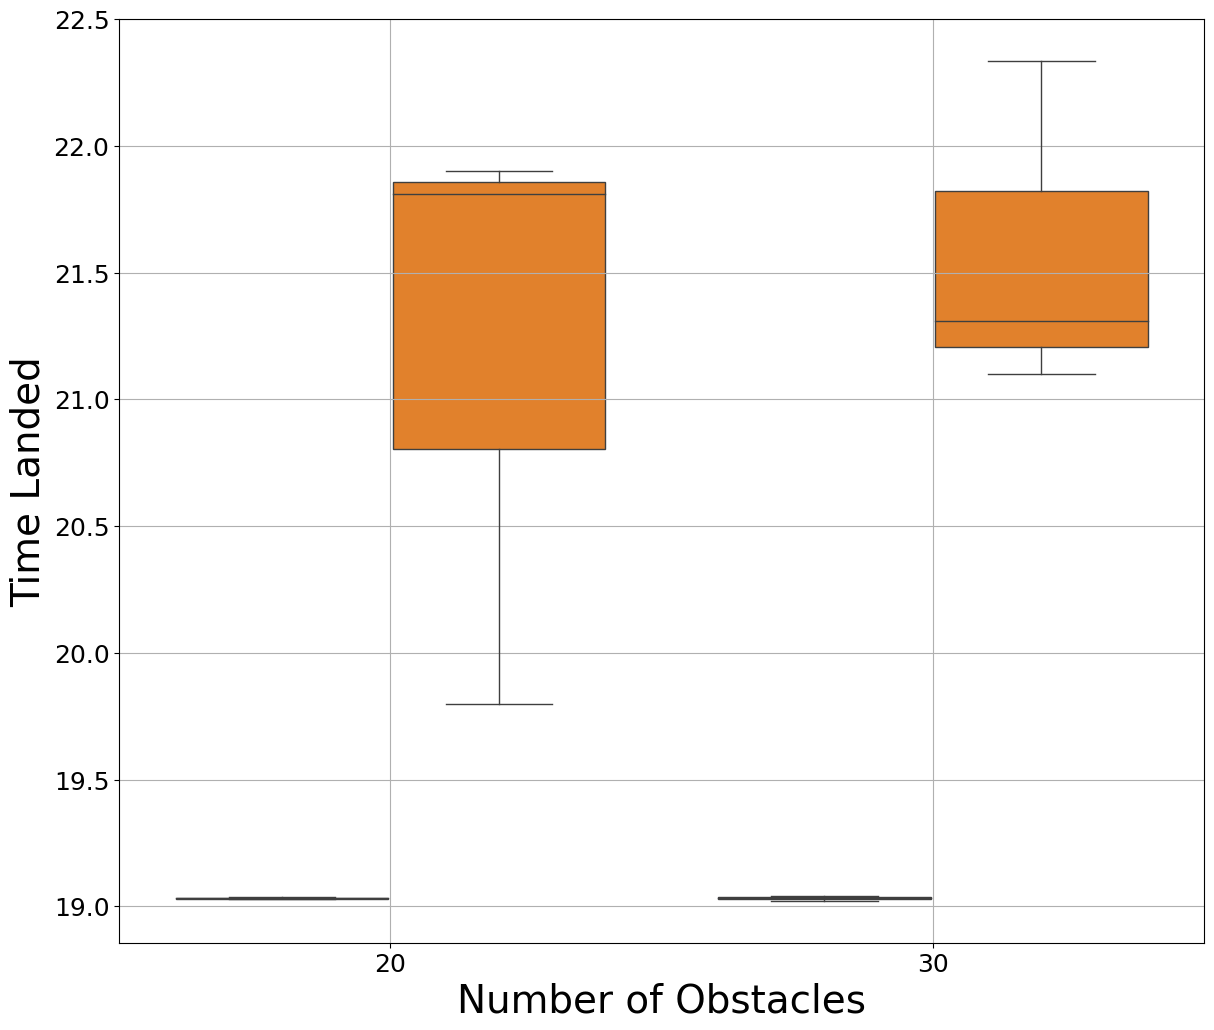

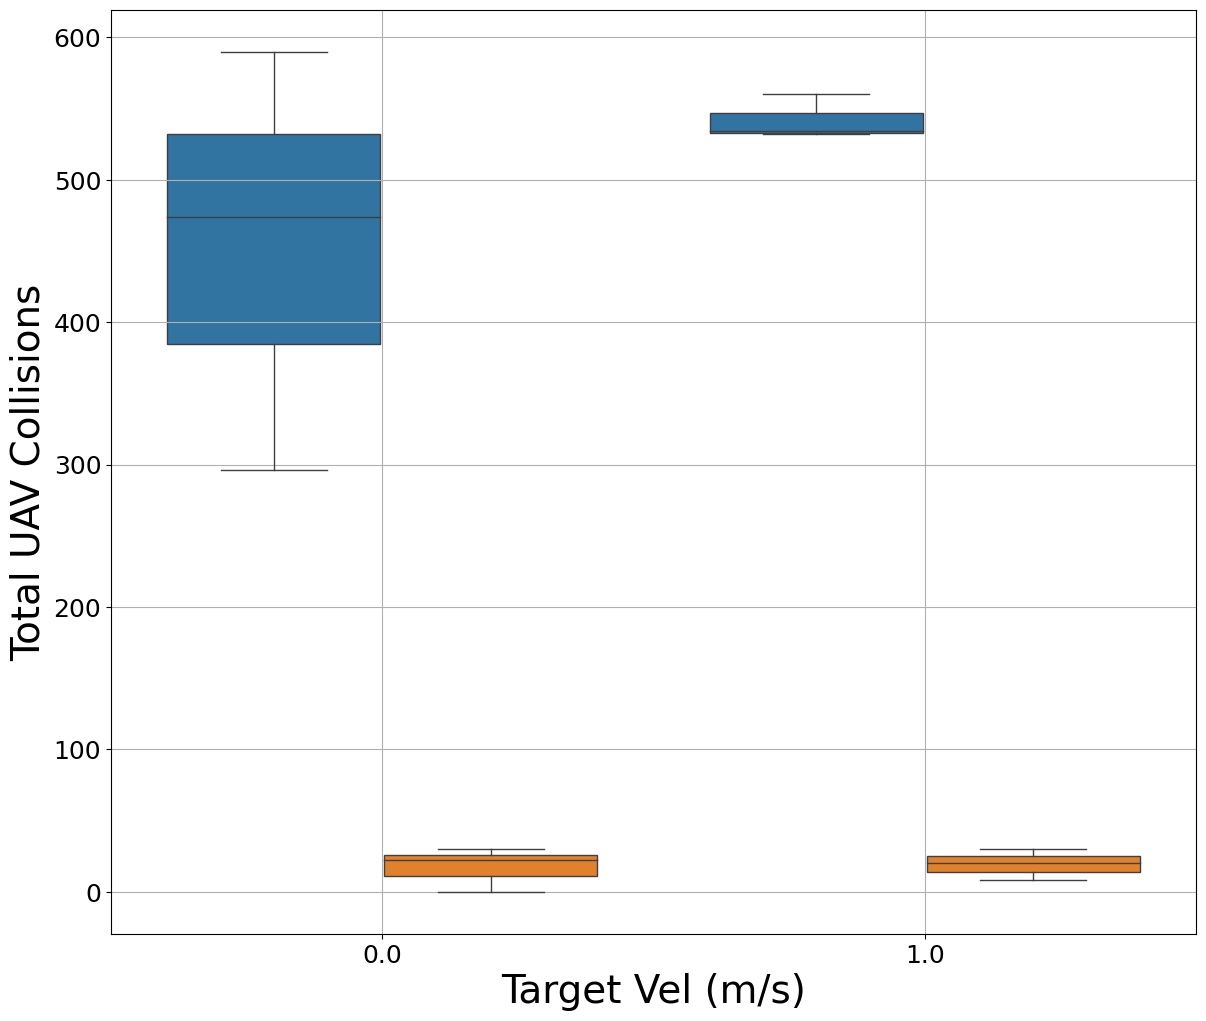

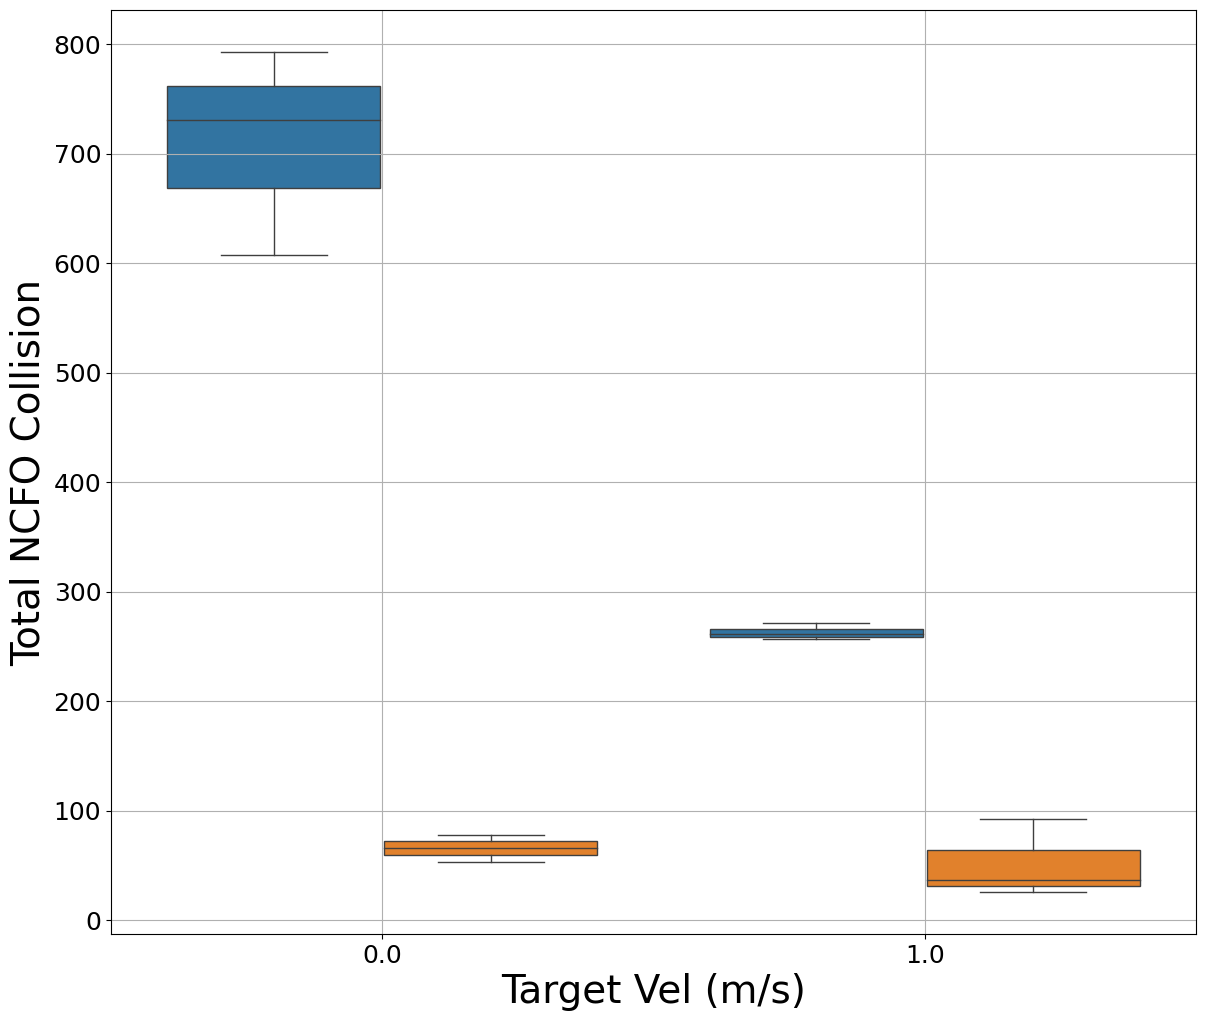

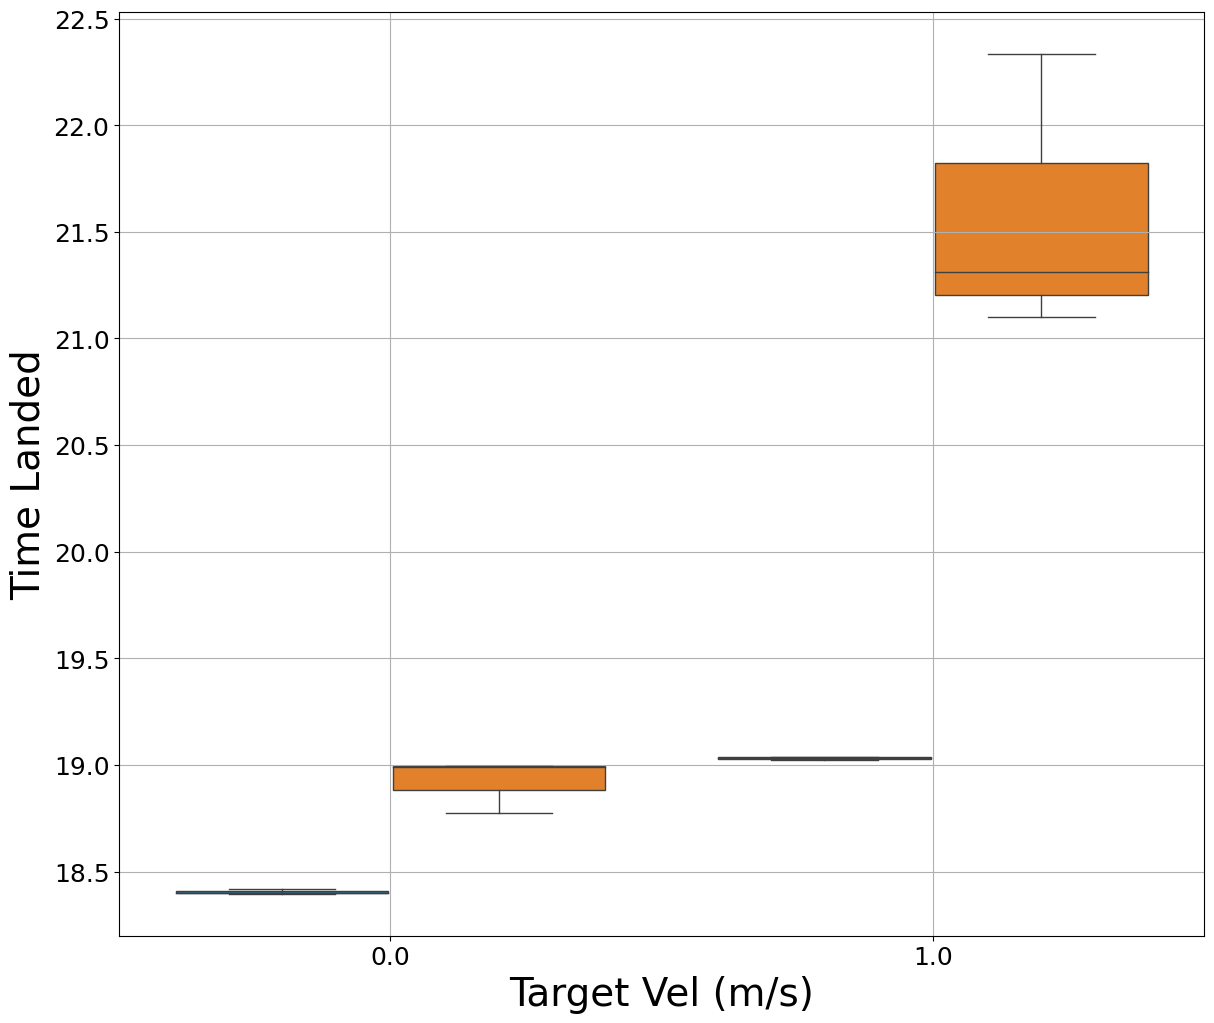

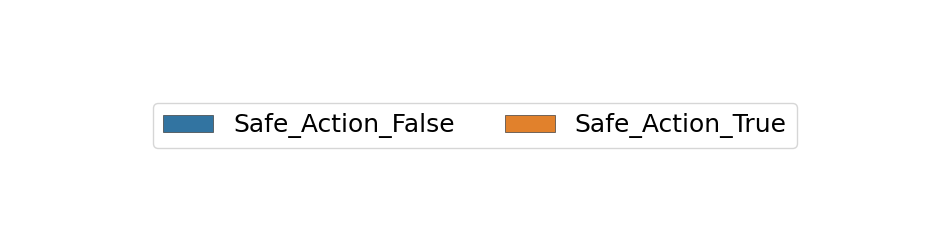

In [116]:
from numpy import imag


groups_to_plot = [
    {
        "group": df.groupby(["target_v"]),
        "group_x": "num_obs",
        "group_key": (1),
        "group_title": "vary_safe_action_tgt_v_0",
        "x_label": "Number of Obstacles",
    },
    {
        "group": df.groupby(["num_obs"]),
        "group_x": "target_v",
        "group_key": (30),
        "group_title": "vary_safe_action_tgt_v_1",
        "x_label": "Target Vel (m/s)",
    },
    # {
    #     "group": df.groupby(["num_obs"]),
    #     "group_x": "safe_action",
    #     "group_key": (30),
    #     "group_title": "fix_obs_vary_pursuer",
    #     "x_label": "Use Safe Layer",
    # },
    # {
    #     "group": df.groupby(["num_pursuers", "observation_radius"]),
    #     "group_x": "num_obstacles",
    #     "group_key": (NUM_PURSUERS, OBSERVATION_RADIUS),
    #     "group_title": "fix_pursuers_vary_obs",
    #     "x_label": "Number of Obstacles",
    # },
    # {
    #     "group": df.groupby(["observation_radius"]),
    #     "group_x": "num_pursuers",
    #     "group_key": (OBSERVATION_RADIUS),
    #     "group_title": "fix_obs_vary_pursuer_all",
    #     "x_label": "Number of Pursuers",
    # },
]

# items_to_plot =[ 'evader_captured', 'episode_reward', 'obstacle_collisions','target_collisions', 'target_breached', 'agent_collisions', 'time_total_s', 'timesteps_total']
items_to_plot = {
    "uav_collision": "Total UAV Collisions",
    "obs_collision": "Total NCFO Collision",
    "uav_done_time": "Time Landed"
    # "evader_captured": "Total Evader Captured",
    # "episode_reward": "Episode Reward",
    # "obstacle_collisions": "Total Pursuer/NCIE Collisions",
    # "target_collisions": "Total Pursuer/Target Collisions",
    # "target_breached": "Total Target Breached",
    # "agent_collisions": "Total Puruser Collisions",
    # "time_total_s": "Total Time (s)",
    # "timesteps_total": "Time Steps Total",
    # "cumulative_episode_reward": "Total Reward",
}

sns.color_palette("colorblind")

labels_to_plot = ["Safe_Action_False", "Safe_Action_True"]

def plot_groups(groups, items, plot_type="box"):
    if plot_type == "bar":
        plot_func = sns.barplot
    elif plot_type == "box":
        plot_func = sns.boxplot
    else:
        raise NameError("unknown plot_type")
    for group in groups:
        for key, value in items.items():
            # fig, ax = plt.subplots(figsize=(12, 10))
            fig, ax = plt.subplots()
            # ax.set_prop_cycle('color', sns.color_palette("colorblind",len(labels_to_plot)))
            # ax.set_prop_cycle('color', sns.color_palette("tab10",len(labels_to_plot)))
            # print(f'group_key{group["group_key"]}')
            group_to_plot = group["group"].get_group(group["group_key"])
            # group_to_plot.safe_action = group_to_plot.safe_action.astype("category")
            # # group_to_plot.checkpoint = group_to_plot.checkpoint.astype("category")
            # group_to_plot.safe_action = group_to_plot.safe_action.cat.set_categories(
            #     labels_to_plot
            # )
            ax = plot_func(
                group_to_plot, hue="safe_action", x=group["group_x"], y=key, ax=ax
            )
            ax.set_ylabel(value)
            ax.set_xlabel(group["x_label"])
            # if item == "episode_reward":
            #     ax.invert_yaxis()
            ax.grid()
            # ax.legend()
            # don't plot legends here. see below
            ax.legend_.remove()

            fig.savefig(os.path.join(image_folder,f"img_{plot_type}_{group['group_title']}_{key}.png"))

    # We're going to create a separate figure with legends.
    # https://stackoverflow.com/questions/4534480/get-legend-as-a-separate-picture-in-matplotlib
    # then create a new image
    # adjust the figure size as necessary
    figsize = (12, 3)
    fig_leg = plt.figure(figsize=figsize)
    ax_leg = fig_leg.add_subplot(111)
    # add the legend from the previous axes
    handles, labels = ax.get_legend_handles_labels()
    ax_leg.legend(handles, labels_to_plot, loc="center", ncol=3)
    # ax_leg.legend(["Safe_True", "safe_false"], loc="center", ncol=3)
    # hide the axes frame and the x/y labels
    ax_leg.axis("off")
    fig_leg.savefig(os.path.join(image_folder, 'plt_label.png'))


plot_groups(groups_to_plot, items_to_plot)
# plot_groups(groups_to_plot, items_to_plot, plot_type="box")


In [138]:
obs_group = df.groupby(["seed", "num_obs", "safe_action", "target_v"])
obs_group.groups.keys()

dict_keys([(0, 20, False, 0.0), (0, 20, False, 1.0), (0, 20, True, 0.0), (0, 20, True, 1.0), (0, 30, False, 0.0), (0, 30, False, 1.0), (0, 30, True, 0.0), (0, 30, True, 1.0), (173, 20, False, 0.0), (173, 20, False, 1.0), (173, 20, True, 0.0), (173, 20, True, 1.0), (173, 30, False, 0.0), (173, 30, False, 1.0), (173, 30, True, 0.0), (173, 30, True, 1.0), (5000, 20, False, 0.0), (5000, 20, False, 1.0), (5000, 20, True, 0.0), (5000, 20, True, 1.0), (5000, 30, False, 0.0), (5000, 30, False, 1.0), (5000, 30, True, 0.0), (5000, 30, True, 1.0)])

In [171]:
from click import group


safe_action = [False, True]
target_v = [0.0, 1.0]

groups_to_plot = []
for action in safe_action:
    for v in target_v:
        groups_to_plot.append((0, 30,action, v))

groups_to_plot
        

[(0, 30, False, 0.0),
 (0, 30, False, 1.0),
 (0, 30, True, 0.0),
 (0, 30, True, 1.0)]

In [172]:

data = obs_group.get_group(groups_to_plot[0])["episode_data"]
data.keys()

Int64Index([10], dtype='int64')

In [173]:

data = obs_group.get_group(groups_to_plot[0])["episode_data"][23]
# data.keys()

KeyError: 23

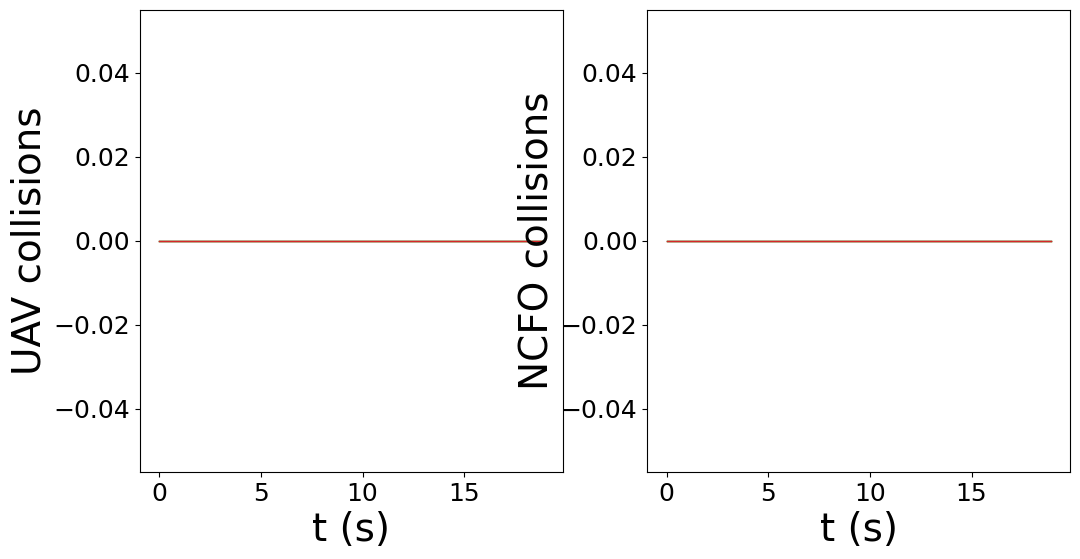

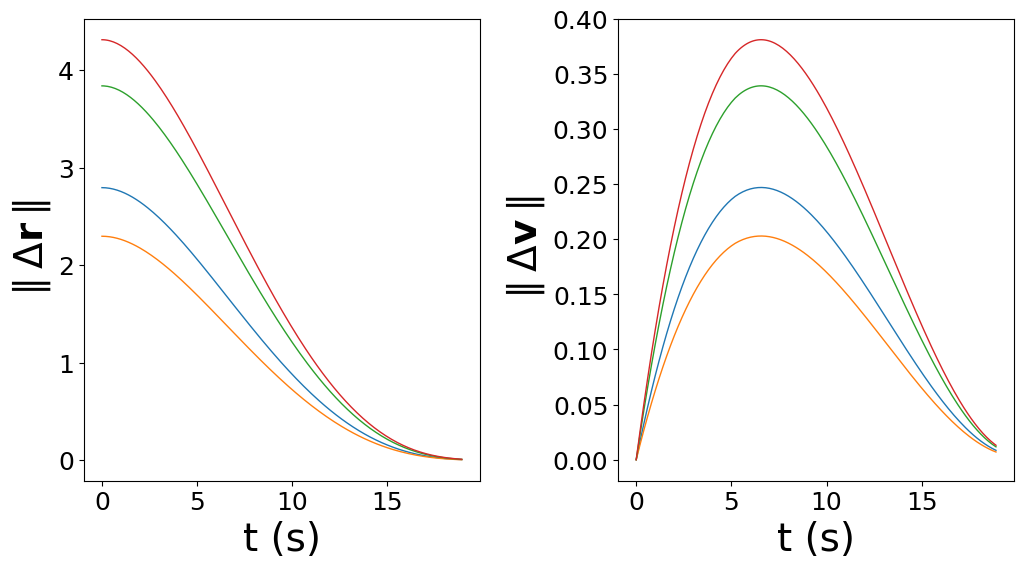

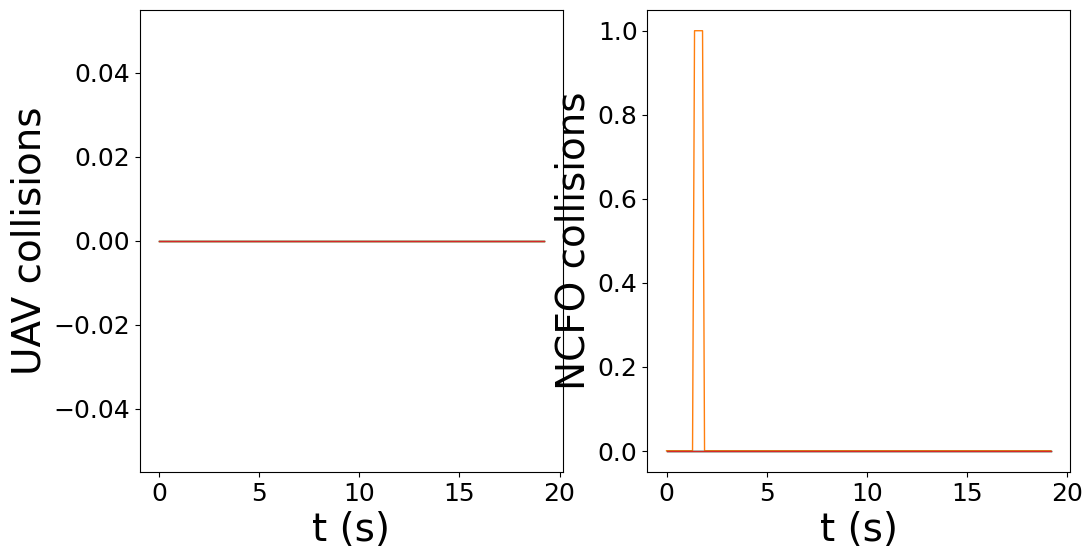

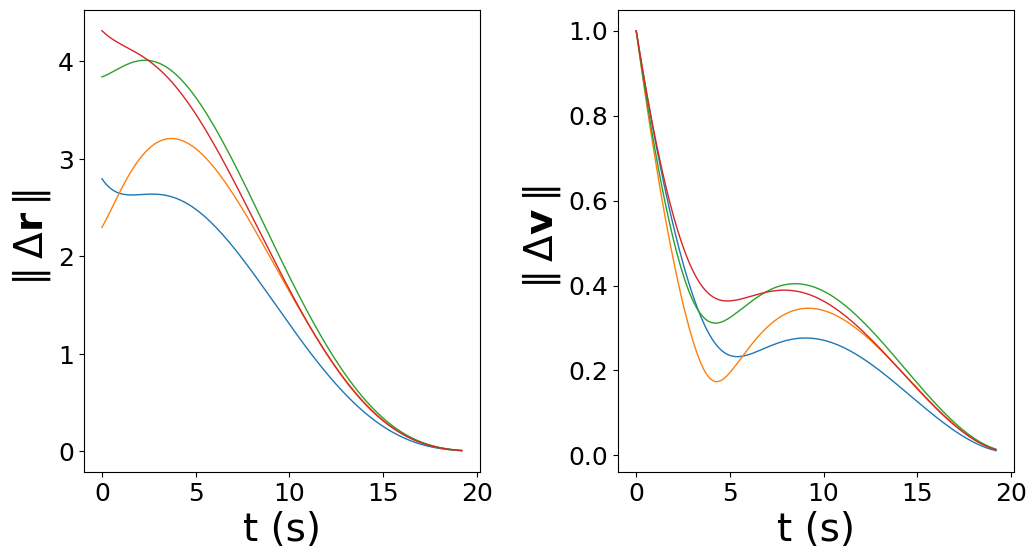

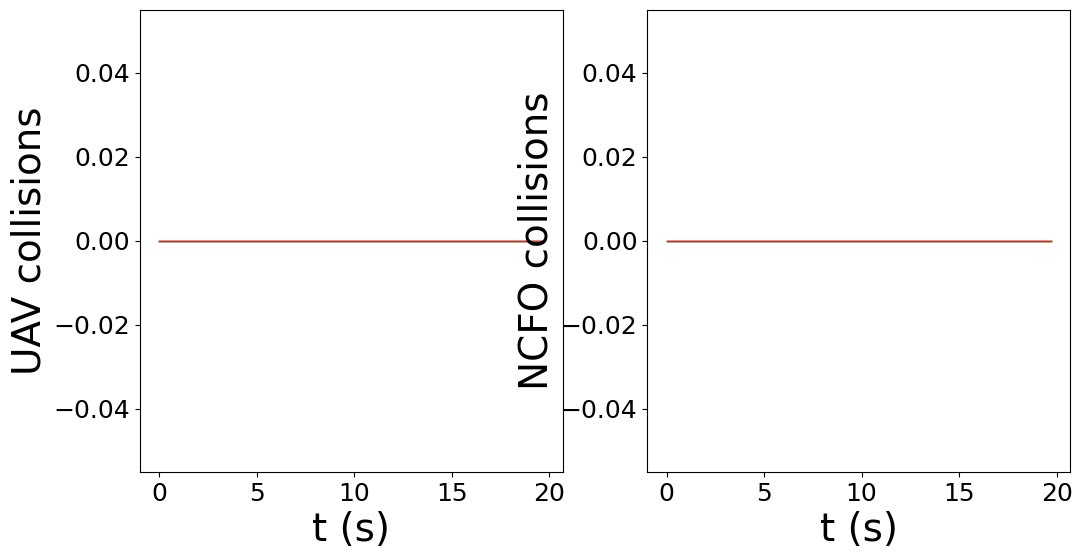

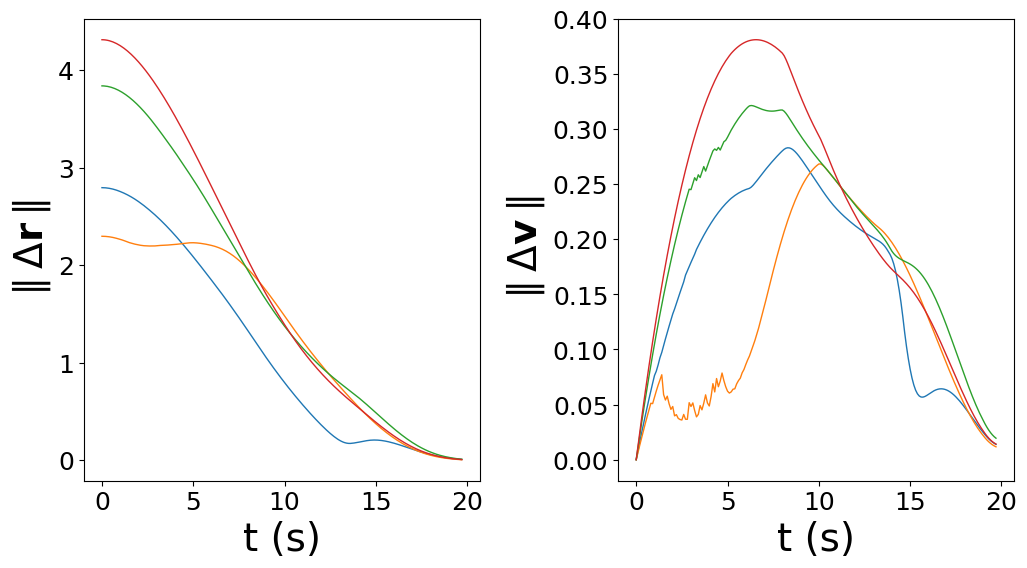

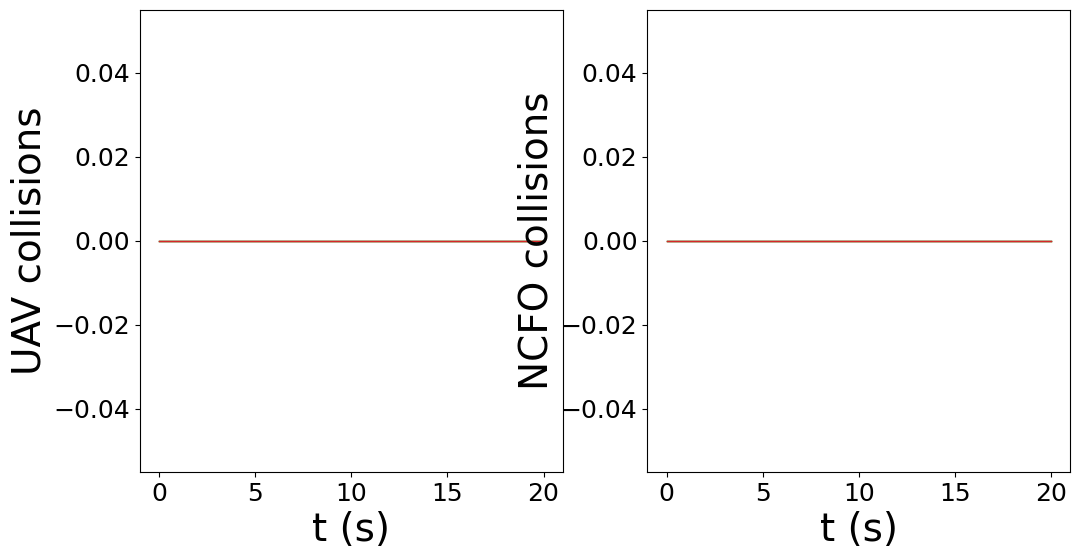

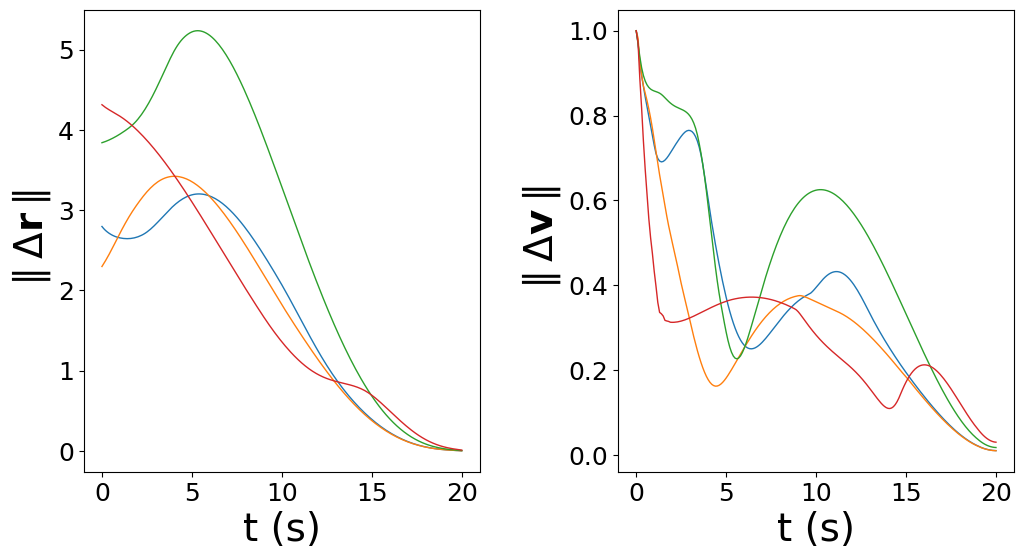

In [174]:

num_uavs = 4
for group_to_plot in groups_to_plot:
    data_group = obs_group.get_group(group_to_plot)["episode_data"]
    key = [key for key in data_group.keys()][0]
    data = data_group[key]

    time_step_list = np.array(data['time_step_list'][0])
    uav_collision_list = np.array(data['uav_collision_list'][0])
    obstacle_collision_list = np.array(data['obstacle_collision_list'][0])
    rel_pad_dist = np.array(data['rel_pad_dist'][0])
    rel_pad_vel = np.array(data['rel_pad_vel'][0])

    all_axes = []
    all_figs = []
    fig = plt.figure(figsize=(12, 6))
    all_axes.append(fig.add_subplot(121))
    all_axes.append(fig.add_subplot(122))
    all_figs.append(fig)


    fig = plt.figure(figsize=(12, 6))
    # fig.tight_layout()
    fig.subplots_adjust(wspace=0.35)
    all_axes.append(fig.add_subplot(121))
    all_axes.append(fig.add_subplot(122))
    all_figs.append(fig)

    for idx in range(num_uavs):
        all_axes[0].plot(
            time_step_list[idx],
            uav_collision_list[idx],
            label=f"uav_{idx}",
        )
        all_axes[1].plot(
            time_step_list[idx],
            obstacle_collision_list[idx],
            label=f"uav_{idx}",
        )
        all_axes[2].plot(
            time_step_list[idx],
            rel_pad_dist[idx],
            label=f"uav_{idx}",
        )
        all_axes[3].plot(
            time_step_list[idx],
            rel_pad_vel[idx],
            label=f"uav_{idx}",
        )

    all_axes[0].set_ylabel("UAV collisions")
    all_axes[1].set_ylabel("NCFO collisions")
    all_axes[2].set_ylabel("$\parallel \Delta \mathbf{r} \parallel$")
    all_axes[3].set_ylabel("$\parallel \Delta \mathbf{v} \parallel$")

    for ax_ in all_axes:
        ax_.set_xlabel("t (s)")

# if not output_folder.exists():
#     output_folder.mkdir(parents=True, exist_ok=True)

# plt_prefix = {
#     "tgt_v": config["target_v"],
#     "sa": config["use_safe_action"],
#     "obs": config["num_obstacles"],
#     "seed": config["seed"],
# }
# plt_prefix = "_".join([f"{k}_{str(int(v))}" for k, v in plt_prefix.items()])

# suffixes = ["collisions.png", "landed.png", "r_v_time.png"]

# # for fig_, suffix in zip(all_figs, suffixes):
# #     file_name = output_folder / f"{plt_prefix}_{suffix}"
# #     fig_.savefig(file_name)
# #     plt.close(fig_)


# figsize = (10, 3)
# fig_leg = plt.figure(figsize=figsize)
# ax_leg = fig_leg.add_subplot(111)
# # add the legend from the previous axes
# ax_leg.legend(*labels, loc="center", ncol=len(labels[1]))
# # hide the axes frame and the x/y labels
# ax_leg.axis("off")
# fig_leg.savefig(output_folder / "labels.png")

# plt.show()

